Import Libraries and Packages

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

Data Download

In [ ]:
import os

save_folder = "tcga_luad"
os.makedirs(save_folder, exist_ok=True)

urls = {

    "mirna.cct":"https://linkedomics.org/data_download/TCGA-LUAD/Human__TCGA_LUAD__BDGSC__miRNASeq__HS_miR__01_28_2016__BI__Gene__Firehose_RPM_log2.cct",
    "rna.cct": "https://linkedomics.org/data_download/TCGA-LUAD/Human__TCGA_LUAD__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct.gz",
    "clinical.tsi": "https://linkedomics.org/data_download/TCGA-LUAD/Human__TCGA_LUAD__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi"
}

for fname, url in urls.items():
    path = f"{save_folder}/{fname}"
    print("Downloading:", fname)
    os.system(f"wget -O {path} {url}")

Downloading: mirna.cct
Downloading: rna.cct
Downloading: clinical.tsi


In [ ]:
import pandas as pd

clinical_raw = pd.read_table("tcga_luad/clinical.tsi")
row_labels = clinical_raw.iloc[:, 0].tolist()
clinical_matrix = clinical_raw.iloc[:, 1:]
# ----------------------------------------------------
# 2. TRANSPOSE so each patient becomes a row
# ----------------------------------------------------
clinical = clinical_matrix.T
clinical.columns = row_labels  # set proper column names
clinical.index.name = "sample_id"
clinical.reset_index(inplace=True)

# Extract survival & status columns and rename
clinical = clinical.rename(columns={
    'OS.time':'overall_survival',
    'OS':'status'
})

clinical['overall_survival'] = pd.to_numeric(clinical['overall_survival'], errors='coerce')
clinical['status'] = pd.to_numeric(clinical['status'], errors='coerce')

clinical = clinical[['sample_id','overall_survival','status']]
clinical.to_csv("clinical_processed.csv", index=False)

print(clinical.head())

      sample_id  overall_survival  status
0  TCGA.05.4245             730.0     0.0
1  TCGA.05.4382             607.0     0.0
2  TCGA.05.4384             426.0     0.0
3  TCGA.05.4396             303.0     1.0
4  TCGA.05.4402             244.0     1.0


In [ ]:
clinical.to_csv("clinical_processed.csv", index=False)
print(clinical.head())

      sample_id  overall_survival  status
0  TCGA.05.4245             730.0     0.0
1  TCGA.05.4382             607.0     0.0
2  TCGA.05.4384             426.0     0.0
3  TCGA.05.4396             303.0     1.0
4  TCGA.05.4402             244.0     1.0


In [ ]:
mirna_raw = pd.read_table("tcga_luad/mirna.cct")
rna_raw = pd.read_table("tcga_luad/rna.cct", compression='gzip')

mirna_t = mirna_raw.set_index("attrib_name").T
rna_t = rna_raw.set_index("attrib_name").T

mirna_t.index.name = "sample_id"
rna_t.index.name = "sample_id"

print(mirna_t.shape, rna_t.shape)

(450, 809) (515, 19988)


mirna Imputation

In [ ]:
def check_nan_values(df):

    nan_columns = mirna_t.columns[mirna_t.isnull().any()].tolist()

    if not nan_columns:
        print("No NaN values found in the DataFrame.")
        return

    print("Columns with NaN values:")
    for col in nan_columns:
        nan_count = mirna_t[col].isnull().sum()
        print(f"  - {col}: {nan_count} NaN values")
mirna_dataframe = pd.DataFrame(mirna_t)

check_nan_values(mirna_dataframe)

No NaN values found in the DataFrame.


In [ ]:
class GAINImputer:
    def __init__(self, input_dim, hint_rate=0.9, alpha=10, epochs=1000, batch_size=128, learning_rate=0.001):
        self.input_dim = input_dim
        self.hint_rate = hint_rate
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        # Generator Network
        self.generator = nn.Sequential(
            nn.Linear(input_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

        # Discriminator Network
        self.discriminator = nn.Sequential(
            nn.Linear(input_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def preprocess_data(self, df):
        """Convert DataFrame to NumPy array and normalize."""
        df.replace(["", "null"], np.nan, inplace=True)
        df = df.apply(pd.to_numeric, errors='coerce')
        df.fillna(np.nan, inplace=True)
        data = df.values
        min_val = np.nanmin(data, axis=0)
        max_val = np.nanmax(data, axis=0)
        norm_data = (data - min_val) / (max_val - min_val + 1e-6)

        mask = ~np.isnan(norm_data)
        norm_data = np.nan_to_num(norm_data, nan=0.0)

        return torch.tensor(norm_data, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32), min_val, max_val

    def train(self, data, mask):
        """Train GAIN model."""
        optimizer_G = optim.Adam(self.generator.parameters(), lr=self.learning_rate)
        optimizer_D = optim.Adam(self.discriminator.parameters(), lr=self.learning_rate)
        loss_fn = nn.BCELoss()

        dataset = torch.utils.data.TensorDataset(data, mask)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for batch_data, batch_mask in dataloader:
                batch_size = batch_data.size(0)

                # Hint Vector
                hint = (torch.rand(batch_size, self.input_dim) < self.hint_rate).float()
                hint_matrix = batch_mask * hint

                # Generator Input
                noise = torch.randn_like(batch_data) * 0.01
                G_input = torch.cat([batch_data * batch_mask + noise, batch_mask], dim=1)

                # Generate Imputed Data
                G_output = self.generator(G_input).detach()
                X_hat = batch_data * batch_mask + G_output * (1 - batch_mask)

                # Discriminator Training
                D_input = torch.cat([X_hat, hint_matrix], dim=1)
                D_output = self.discriminator(D_input)

                D_loss = loss_fn(D_output, batch_mask)
                optimizer_D.zero_grad()
                D_loss.backward()
                optimizer_D.step()

                # Generator Training
                G_output = self.generator(G_input)
                X_hat = batch_data * batch_mask + G_output * (1 - batch_mask)

                D_output_G = self.discriminator(torch.cat([X_hat, hint_matrix], dim=1))
                G_loss = loss_fn(D_output_G, 1 - batch_mask)
                MSE_loss = torch.nn.functional.mse_loss(G_output, batch_data, reduction='mean')
                G_total_loss = G_loss + self.alpha * MSE_loss
                optimizer_G.zero_grad()
                G_total_loss.backward()
                optimizer_G.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, D Loss: {D_loss.item():.4f}, G Loss: {G_total_loss.item():.4f}")
    def impute(self, data, mask, min_val, max_val):
        """Impute missing values using trained GAIN model."""
        self.generator.eval()
        with torch.no_grad():
            G_input = torch.cat([data, mask], dim=1)
            G_output = self.generator(G_input)
            imputed_data = data * mask + G_output * (1 - mask)
            imputed_data = imputed_data.numpy()

            # Denormalize
            imputed_data = imputed_data * (max_val - min_val + 1e-6) + min_val
        return imputed_data

    def fit_transform(self, df):
        data, mask, min_val, max_val = self.preprocess_data(df)
        self.train(data, mask)
        imputed_data = self.impute(data, mask, min_val, max_val)
        return pd.DataFrame(imputed_data, columns=df.columns, index=df.index)

In [ ]:
import pandas as pd
import numpy as np

def replace_missing_with_nan(matrix):

    matrix = matrix.replace(r'^\s*$', np.nan, regex=True)
    matrix = matrix.replace('NaN', np.nan)

    return matrix
my_matrix = pd.DataFrame(mirna_t)
print("Original Matrix:")
print(my_matrix)
print("\nData types before replacement:")
print(my_matrix.dtypes)
processed_matrix = replace_missing_with_nan(my_matrix)

print("\nMatrix after replacing blanks and 'NaN' with np.nan:")
print(processed_matrix)
print("\nData types after replacement:")
print(processed_matrix.dtypes)

Original Matrix:
attrib_name   hsa-let-7a-1  hsa-let-7a-2  hsa-let-7a-3  hsa-let-7b  \
sample_id                                                            
TCGA.05.4384       13.8766       14.8745       13.8822     13.8259   
TCGA.05.4390       11.7425       12.7576       11.7578     13.0601   
TCGA.05.4396       14.0194       15.0255       14.0367     14.5902   
TCGA.05.4405       12.9428       13.9327       12.9499     14.2170   
TCGA.05.4410       12.7150       13.7157       12.7252     13.7465   
...                    ...           ...           ...         ...   
TCGA.NJ.A55O       13.7260       14.7255       13.7416     13.8372   
TCGA.NJ.A55R       12.3826       13.3917       12.3986     12.8563   
TCGA.NJ.A7XG       12.6324       13.6234       12.6361     13.4904   
TCGA.O1.A52J       11.9579       12.9604       11.9678     12.5495   
TCGA.S2.AA1A       13.2691       14.2701       13.2772     14.0370   

attrib_name   hsa-let-7c  hsa-let-7d  hsa-let-7e  hsa-let-7f-1  hsa-let-

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(processed_matrix)
train_data = pd.DataFrame(scaler.transform(processed_matrix))

In [ ]:

df=train_data
gain_imputer = GAINImputer(input_dim=df.shape[1])


df_imputed = gain_imputer.fit_transform(df)
df_imputed.to_csv("imputed_mirna_data.csv", index=True)

Epoch 0, D Loss: 0.4828, G Loss: 2.4105
Epoch 100, D Loss: 0.0000, G Loss: 100.1286
Epoch 200, D Loss: 0.0000, G Loss: 100.0942
Epoch 300, D Loss: 0.0000, G Loss: 100.0809
Epoch 400, D Loss: 0.0000, G Loss: 100.0655
Epoch 500, D Loss: 0.0000, G Loss: 100.0632
Epoch 600, D Loss: 0.0000, G Loss: 100.0547
Epoch 700, D Loss: 0.0000, G Loss: 100.0479
Epoch 800, D Loss: 0.0000, G Loss: 100.0440
Epoch 900, D Loss: 0.0000, G Loss: 100.0436


In [ ]:
mirna = pd.read_table('/C:/tcga_luad/mirna.cct')

In [ ]:

gene_names = mirna['attrib_name'].tolist()
original_sample_ids = mirna_t.index
mirna_data = df_imputed.reset_index()
mirna_data = mirna_data.drop(columns=['index'])
mirna_data['sample_id'] = original_sample_ids.to_list()
mirna_data = mirna_data[['sample_id'] + [col for col in mirna_data.columns if col != 'sample_id']]
mirna_data.columns = ['sample_id'] + gene_names
mirna_data.to_csv('imputed_mirna_data_with_genes.csv', index=False)
mirna_data

,sample_id,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,...,hsa-mir-940,hsa-mir-941-1,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
0,TCGA.05.4384,0.809766,0.810838,0.811275,0.617235,0.647099,0.562068,0.632532,0.772509,0.938815,...,0.181417,0.000000,0.369088,0.000000,0.321104,0.291152,0.271172,0.594769,0.528317,0.376400
1,TCGA.05.4390,0.332200,0.339127,0.331065,0.495880,0.159034,0.543383,0.557402,0.258591,0.442602,...,0.475696,0.000000,0.376333,0.583949,0.057080,0.600806,0.490814,0.759518,0.033027,0.614402
2,TCGA.05.4396,0.841721,0.844486,0.846199,0.738353,0.728084,0.784777,0.749942,0.526326,0.798463,...,0.221347,0.116093,0.366594,0.136002,0.078941,0.314933,0.368539,0.695647,0.481086,0.235895
3,TCGA.05.4405,0.600801,0.600976,0.600533,0.679212,0.726819,0.517212,0.539441,0.202379,0.455931,...,0.329780,0.000000,0.296362,0.000000,0.265297,0.160668,0.546187,0.440893,0.570379,0.271390
4,TCGA.05.4410,0.549824,0.552622,0.549741,0.604653,0.605520,0.566803,0.476985,0.402951,0.547103,...,0.221383,0.000000,0.486541,0.000000,0.172762,0.098216,0.421425,0.376883,0.530081,0.211916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,TCGA.NJ.A55O,0.776065,0.777637,0.779493,0.619026,0.649175,0.684199,0.695825,0.979608,0.835380,...,0.092914,0.000000,0.302625,0.000000,0.156386,0.524327,0.373274,0.574724,0.634223,0.228733
446,TCGA.NJ.A55R,0.475440,0.480424,0.475915,0.463584,0.432313,0.534050,0.556936,0.487727,0.483049,...,0.237026,0.000000,0.253932,0.000000,0.076419,0.556222,0.780564,0.471692,0.465608,0.292367
447,TCGA.NJ.A7XG,0.531340,0.532054,0.529601,0.564069,0.572941,0.380757,0.482116,0.542456,0.457953,...,0.075503,0.000000,0.107754,0.146792,0.362211,0.134096,0.465906,0.317558,0.532827,0.231471
448,TCGA.O1.A52J,0.380401,0.384317,0.378535,0.414966,0.676305,0.628910,0.461609,0.639478,0.531769,...,0.315993,0.000000,0.365102,0.000000,0.126534,0.205122,0.424891,0.826948,0.627044,0.314696


RNA Imputation

In [ ]:
def check_nan_values(df):
    nan_columns = rna_t.columns[rna_t.isnull().any()].tolist()

    if not nan_columns:
        print("No NaN values found in the DataFrame.")
        return

    print("Columns with NaN values:")
    for col in nan_columns:
        nan_count = rna_t[col].isnull().sum()
        print(f"  - {col}: {nan_count} NaN values")
rna_dataframe = pd.DataFrame(rna_t)

check_nan_values(rna_dataframe)

No NaN values found in the DataFrame.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

class GAINImputer:
    def __init__(self, input_dim, hint_rate=0.9, alpha=10, epochs=100, batch_size=128, learning_rate=0.001):
        self.input_dim = input_dim
        self.hint_rate = hint_rate
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        # Generator Network
        self.generator = nn.Sequential(
            nn.Linear(input_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

        # Discriminator Network
        self.discriminator = nn.Sequential(
            nn.Linear(input_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def preprocess_data(self, df):

        df.replace(["", "null"], np.nan, inplace=True)
        df = df.apply(pd.to_numeric, errors='coerce')
        df.fillna(np.nan, inplace=True)

        data = df.values
        min_val = np.nanmin(data, axis=0)
        max_val = np.nanmax(data, axis=0)
        norm_data = (data - min_val) / (max_val - min_val + 1e-6)

        mask = ~np.isnan(norm_data)
        norm_data = np.nan_to_num(norm_data, nan=0.0)

        return torch.tensor(norm_data, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32), min_val, max_val

    def train(self, data, mask):

        optimizer_G = optim.Adam(self.generator.parameters(), lr=self.learning_rate)
        optimizer_D = optim.Adam(self.discriminator.parameters(), lr=self.learning_rate)
        loss_fn = nn.BCELoss()

        dataset = torch.utils.data.TensorDataset(data, mask)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for batch_data, batch_mask in dataloader:
                batch_size = batch_data.size(0)


                hint = (torch.rand(batch_size, self.input_dim) < self.hint_rate).float()
                hint_matrix = batch_mask * hint


                noise = torch.randn_like(batch_data) * 0.01
                G_input = torch.cat([batch_data * batch_mask + noise, batch_mask], dim=1)


                G_output = self.generator(G_input).detach()
                X_hat = batch_data * batch_mask + G_output * (1 - batch_mask)


                D_input = torch.cat([X_hat, hint_matrix], dim=1)
                D_output = self.discriminator(D_input)

                D_loss = loss_fn(D_output, batch_mask)
                optimizer_D.zero_grad()
                D_loss.backward()
                optimizer_D.step()


                G_output = self.generator(G_input)
                X_hat = batch_data * batch_mask + G_output * (1 - batch_mask)

                D_output_G = self.discriminator(torch.cat([X_hat, hint_matrix], dim=1))
                G_loss = loss_fn(D_output_G, 1 - batch_mask)
                MSE_loss = torch.nn.functional.mse_loss(G_output, batch_data, reduction='mean')
                G_total_loss = G_loss + self.alpha * MSE_loss
                optimizer_G.zero_grad()
                G_total_loss.backward()
                optimizer_G.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, D Loss: {D_loss.item():.4f}, G Loss: {G_total_loss.item():.4f}")
    def impute(self, data, mask, min_val, max_val):

        self.generator.eval()
        with torch.no_grad():
            G_input = torch.cat([data, mask], dim=1)
            G_output = self.generator(G_input)
            imputed_data = data * mask + G_output * (1 - mask)
            imputed_data = imputed_data.numpy()


            imputed_data = imputed_data * (max_val - min_val + 1e-6) + min_val
        return imputed_data

    def fit_transform(self, df):

        data, mask, min_val, max_val = self.preprocess_data(df)
        self.train(data, mask)
        imputed_data = self.impute(data, mask, min_val, max_val)
        return pd.DataFrame(imputed_data, columns=df.columns, index=df.index)

In [ ]:
import pandas as pd
import numpy as np

def replace_missing_with_nan(matrix):
    matrix = matrix.replace(r'^\s*$', np.nan, regex=True)
    matrix = matrix.replace('NaN', np.nan)
    return matrix
my_matrix = pd.DataFrame(rna_t)

print("Original Matrix:")
print(my_matrix)
print("\nData types before replacement:")
print(my_matrix.dtypes)
processed_matrix = replace_missing_with_nan(my_matrix)
print("\nMatrix after replacing blanks and 'NaN' with np.nan:")
print(processed_matrix)
print("\nData types after replacement:")
print(processed_matrix.dtypes)

Original Matrix:
attrib_name     A1BG    A1CF   A2BP1   A2LD1   A2ML1      A2M  A4GALT  \
sample_id                                                               
TCGA.05.4244  4.7565  0.0000  1.4570  7.0928  0.4320  13.2653  7.0433   
TCGA.05.4249  6.9205  0.4027  1.3839  6.4929  1.3839  14.6502  9.1788   
TCGA.05.4250  5.6965  0.0000  0.0000  7.2492  0.0000  14.0485  8.4816   
TCGA.05.4382  7.1987  0.0000  0.0000  6.8211  2.5326  14.5097  9.1176   
TCGA.05.4384  7.0041  0.0000  0.0000  6.4688  0.0000  15.5602  7.2641   
...              ...     ...     ...     ...     ...      ...     ...   
TCGA.NJ.A55O  5.4265  0.0000  0.0000  6.7404  3.2856  14.4514  9.8939   
TCGA.NJ.A55R  8.1028  5.9771  3.2706  5.6088  0.3107  14.7763  7.8708   
TCGA.NJ.A7XG  7.9482  0.0000  4.0100  6.6592  1.9060  12.0664  8.5670   
TCGA.O1.A52J  7.7171  0.0000  0.9686  4.9336  0.0000  14.6769  5.8564   
TCGA.S2.AA1A  6.8524  0.7270  0.0000  6.9540  0.0000  15.6981  8.0285   

attrib_name     A4GNT    AAA1    

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(processed_matrix)
train_data = pd.DataFrame(scaled_values, index=processed_matrix.index, columns=processed_matrix.columns)

In [ ]:

df=train_data
gain_imputer = GAINImputer(input_dim=df.shape[1])
df_imputed = gain_imputer.fit_transform(df)
df_imputed.to_csv("imputed_data.csv", index=True)

Epoch 0, D Loss: 0.4861, G Loss: 2.4965


In [ ]:
df_imputed

attrib_name,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA.05.4244,0.295015,0.000000,0.153038,0.675626,0.029167,0.362568,0.350087,0.088994,0.000000,0.464040,...,0.458034,0.543216,0.495202,0.085966,0.634735,0.523282,0.569970,0.308420,0.204749,0.000000
TCGA.05.4249,0.508360,0.042673,0.145360,0.538513,0.093435,0.577849,0.655010,0.061737,0.085406,0.430386,...,0.599100,0.676666,0.586181,0.496461,0.489545,0.470047,0.668025,0.366863,0.633933,0.000000
TCGA.05.4250,0.387688,0.000000,0.000000,0.711373,0.000000,0.484315,0.555459,0.085765,0.258340,0.418468,...,0.588085,0.599950,0.438757,0.538234,0.262769,0.707317,0.678337,0.283863,0.198726,0.000000
TCGA.05.4382,0.535788,0.000000,0.000000,0.613526,0.170991,0.556008,0.646272,0.142655,0.272401,0.433366,...,0.463116,0.586582,0.489396,0.679837,0.553554,0.769362,0.677929,0.354328,0.415690,0.000000
TCGA.05.4384,0.516602,0.000000,0.000000,0.533004,0.000000,0.719307,0.381615,0.129320,0.000000,0.474203,...,0.679674,0.710370,0.636055,0.355668,0.484590,0.569511,0.823293,0.381846,0.734193,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.NJ.A55O,0.361069,0.000000,0.000000,0.595081,0.221831,0.546945,0.757118,0.186830,0.000000,0.461657,...,0.466205,0.573232,0.558432,0.473740,0.453239,0.633244,0.726231,0.313897,0.781419,0.000000
TCGA.NJ.A55R,0.624921,0.633375,0.343532,0.336442,0.020977,0.597451,0.468244,0.122536,0.450828,0.613556,...,0.534556,0.606120,0.687825,0.646493,0.472311,0.546239,0.873020,0.328146,0.828176,0.295788
TCGA.NJ.A7XG,0.609679,0.000000,0.421196,0.576522,0.128686,0.176201,0.567653,0.000000,0.000000,0.424991,...,0.192760,0.403489,0.602897,0.390407,0.313191,0.423582,0.750318,0.212730,0.182883,0.000000


In [ ]:
rna = pd.read_table('/C:/tcga_luad/rna.cct', compression='gzip')

In [ ]:
gene_names = rna['attrib_name'].tolist()
original_sample_ids = rna_t.index
rna_data = df_imputed.reset_index()
rna_data = rna_data[['sample_id'] + [col for col in rna_data.columns if col != 'sample_id']]
rna_data.to_csv('imputed_rna_data_with_genes.csv', index=False)
rna_data

attrib_name,sample_id,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,TCGA.05.4244,0.295015,0.000000,0.153038,0.675626,0.029167,0.362568,0.350087,0.088994,0.000000,...,0.458034,0.543216,0.495202,0.085966,0.634735,0.523282,0.569970,0.308420,0.204749,0.000000
1,TCGA.05.4249,0.508360,0.042673,0.145360,0.538513,0.093435,0.577849,0.655010,0.061737,0.085406,...,0.599100,0.676666,0.586181,0.496461,0.489545,0.470047,0.668025,0.366863,0.633933,0.000000
2,TCGA.05.4250,0.387688,0.000000,0.000000,0.711373,0.000000,0.484315,0.555459,0.085765,0.258340,...,0.588085,0.599950,0.438757,0.538234,0.262769,0.707317,0.678337,0.283863,0.198726,0.000000
3,TCGA.05.4382,0.535788,0.000000,0.000000,0.613526,0.170991,0.556008,0.646272,0.142655,0.272401,...,0.463116,0.586582,0.489396,0.679837,0.553554,0.769362,0.677929,0.354328,0.415690,0.000000
4,TCGA.05.4384,0.516602,0.000000,0.000000,0.533004,0.000000,0.719307,0.381615,0.129320,0.000000,...,0.679674,0.710370,0.636055,0.355668,0.484590,0.569511,0.823293,0.381846,0.734193,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,TCGA.NJ.A55O,0.361069,0.000000,0.000000,0.595081,0.221831,0.546945,0.757118,0.186830,0.000000,...,0.466205,0.573232,0.558432,0.473740,0.453239,0.633244,0.726231,0.313897,0.781419,0.000000
511,TCGA.NJ.A55R,0.624921,0.633375,0.343532,0.336442,0.020977,0.597451,0.468244,0.122536,0.450828,...,0.534556,0.606120,0.687825,0.646493,0.472311,0.546239,0.873020,0.328146,0.828176,0.295788
512,TCGA.NJ.A7XG,0.609679,0.000000,0.421196,0.576522,0.128686,0.176201,0.567653,0.000000,0.000000,...,0.192760,0.403489,0.602897,0.390407,0.313191,0.423582,0.750318,0.212730,0.182883,0.000000
513,TCGA.O1.A52J,0.586896,0.000000,0.101738,0.182117,0.000000,0.581999,0.180612,0.195551,0.000000,...,0.850180,0.710122,0.627957,0.063481,0.486553,0.652709,0.774355,0.249043,0.638471,0.146569


In [ ]:
mirna_imputed=pd.read_csv("/C:/imputed_mirna_data_with_genes.csv")

In [ ]:
mirna_imputed

,sample_id,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,...,hsa-mir-940,hsa-mir-941-1,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
0,TCGA.05.4384,0.809766,0.810838,0.811275,0.617235,0.647099,0.562068,0.632532,0.772509,0.938815,...,0.181417,0.000000,0.369088,0.000000,0.321104,0.291152,0.271172,0.594769,0.528317,0.376400
1,TCGA.05.4390,0.332200,0.339127,0.331065,0.495880,0.159034,0.543383,0.557402,0.258591,0.442602,...,0.475696,0.000000,0.376333,0.583949,0.057080,0.600806,0.490814,0.759518,0.033027,0.614402
2,TCGA.05.4396,0.841721,0.844486,0.846199,0.738353,0.728084,0.784777,0.749942,0.526326,0.798463,...,0.221347,0.116093,0.366594,0.136002,0.078941,0.314933,0.368539,0.695647,0.481086,0.235895
3,TCGA.05.4405,0.600801,0.600976,0.600533,0.679212,0.726819,0.517212,0.539441,0.202379,0.455931,...,0.329780,0.000000,0.296362,0.000000,0.265297,0.160668,0.546187,0.440893,0.570379,0.271390
4,TCGA.05.4410,0.549824,0.552622,0.549741,0.604653,0.605520,0.566803,0.476985,0.402951,0.547103,...,0.221383,0.000000,0.486541,0.000000,0.172762,0.098216,0.421425,0.376883,0.530081,0.211916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,TCGA.NJ.A55O,0.776065,0.777637,0.779493,0.619026,0.649175,0.684199,0.695825,0.979608,0.835380,...,0.092914,0.000000,0.302625,0.000000,0.156386,0.524327,0.373274,0.574724,0.634223,0.228733
446,TCGA.NJ.A55R,0.475440,0.480424,0.475915,0.463584,0.432313,0.534050,0.556936,0.487727,0.483049,...,0.237026,0.000000,0.253932,0.000000,0.076419,0.556222,0.780564,0.471692,0.465608,0.292367
447,TCGA.NJ.A7XG,0.531340,0.532054,0.529601,0.564069,0.572941,0.380757,0.482116,0.542456,0.457953,...,0.075503,0.000000,0.107754,0.146792,0.362211,0.134096,0.465906,0.317558,0.532827,0.231471
448,TCGA.O1.A52J,0.380401,0.384317,0.378535,0.414966,0.676305,0.628910,0.461609,0.639478,0.531769,...,0.315993,0.000000,0.365102,0.000000,0.126534,0.205122,0.424891,0.826948,0.627044,0.314696


In [ ]:
rna_imputed=pd.read_csv("/C:/imputed_rna_data_with_genes.csv")

In [ ]:
rna_imputed

,sample_id,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,TCGA.05.4244,0.295015,0.000000,0.153038,0.675626,0.029167,0.362568,0.350087,0.088994,0.000000,...,0.458034,0.543216,0.495202,0.085966,0.634735,0.523282,0.569970,0.308420,0.204749,0.000000
1,TCGA.05.4249,0.508360,0.042673,0.145360,0.538513,0.093435,0.577849,0.655010,0.061737,0.085406,...,0.599100,0.676666,0.586181,0.496461,0.489545,0.470047,0.668025,0.366863,0.633933,0.000000
2,TCGA.05.4250,0.387688,0.000000,0.000000,0.711373,0.000000,0.484315,0.555459,0.085765,0.258340,...,0.588085,0.599950,0.438757,0.538234,0.262769,0.707317,0.678337,0.283863,0.198726,0.000000
3,TCGA.05.4382,0.535788,0.000000,0.000000,0.613526,0.170991,0.556008,0.646272,0.142655,0.272401,...,0.463116,0.586582,0.489396,0.679837,0.553554,0.769362,0.677929,0.354328,0.415690,0.000000
4,TCGA.05.4384,0.516602,0.000000,0.000000,0.533004,0.000000,0.719307,0.381615,0.129320,0.000000,...,0.679674,0.710370,0.636055,0.355668,0.484590,0.569511,0.823293,0.381846,0.734193,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,TCGA.NJ.A55O,0.361069,0.000000,0.000000,0.595081,0.221831,0.546945,0.757118,0.186830,0.000000,...,0.466205,0.573232,0.558432,0.473740,0.453239,0.633244,0.726231,0.313897,0.781419,0.000000
511,TCGA.NJ.A55R,0.624921,0.633375,0.343532,0.336442,0.020977,0.597451,0.468244,0.122536,0.450828,...,0.534556,0.606120,0.687825,0.646493,0.472311,0.546239,0.873020,0.328146,0.828176,0.295788
512,TCGA.NJ.A7XG,0.609679,0.000000,0.421196,0.576522,0.128686,0.176201,0.567653,0.000000,0.000000,...,0.192760,0.403489,0.602897,0.390407,0.313191,0.423582,0.750318,0.212730,0.182883,0.000000
513,TCGA.O1.A52J,0.586896,0.000000,0.101738,0.182117,0.000000,0.581999,0.180612,0.195551,0.000000,...,0.850180,0.710122,0.627957,0.063481,0.486553,0.652709,0.774355,0.249043,0.638471,0.146569


In [ ]:
mirna_merged = mirna_imputed.merge(clinical, on="sample_id", how="inner")
print("miRNA Samples merged:", mirna_merged.shape)

miRNA Samples merged: (450, 812)


In [ ]:
rna_merged = rna_imputed.merge(clinical, on="sample_id", how="inner")
print("RNA Samples merged:", rna_merged.shape)


RNA Samples merged: (515, 19991)


In [ ]:
def lasso_survival(df, label):
    df['overall_survival'] = pd.to_numeric(df['overall_survival'], errors='coerce')
    X = df.drop(columns=['overall_survival','status','sample_id'])
    y = df['overall_survival'].fillna(df['overall_survival'].mean())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y_log = np.log1p(y)
    lasso = LassoCV(cv=5, random_state=42, max_iter=50000)
    lasso.fit(X_scaled, y_log)
    important = X.columns[lasso.coef_ != 0]
    print(f"{label} selected features: {len(important)}")
    print(important)
    return important

mirna_features = lasso_survival(mirna_merged, "miRNA")

miRNA selected features: 5
Index(['hsa-mir-122', 'hsa-mir-1290', 'hsa-mir-29c', 'hsa-mir-374a',
       'hsa-mir-876'],
      dtype='object')


In [ ]:
rna_features = lasso_survival(rna_merged, "RNA")


RNA selected features: 16
Index(['C15orf28', 'C1orf172', 'CLVS2', 'CYP17A1', 'DHDDS', 'HPX', 'HSDL1',
       'INVS', 'LASS4', 'LDLRAD3', 'MAGEB18', 'NTS', 'SGK196', 'USP50',
       'WFDC2', 'ZNF121'],
      dtype='object')


In [ ]:

selected_mirnas = list(mirna_features)
selected_genes  = list(rna_features)


In [ ]:
import pandas as pd

file = "miRTarBase_MTI.csv"
mirtar = pd.read_csv(file)
MIR_COL = "miRNA"
GENE_COL = "Target Gene"
print("\nUsing columns:", MIR_COL, GENE_COL)
miRNAs = ['hsa-mir-122', 'hsa-mir-1290', 'hsa-mir-29c', 'hsa-mir-374a', 'hsa-mir-876']
def find_targets(mirtar, mir_list):
    mirtar[MIR_COL] = mirtar[MIR_COL].str.lower().str.strip()
    results = {}
    for mir in mir_list:
        q = mir.lower().strip()
        variants = {
            q,
            q + "-5p",
            q + "-3p",
            q.replace("hsa-", ""),
            q.replace("hsa-", "") + "-5p",
            q.replace("hsa-", "") + "-3p"
        }
        print("\nSearching for:", mir)
        print("Variants:", variants)
        df = mirtar[mirtar[MIR_COL].isin(variants)]
        genes = df[GENE_COL].dropna().unique().tolist()
        print("Found genes:", genes)
        results[mir] = genes
    return results
targets = find_targets(mirtar, miRNAs)
print("\nFINAL TARGET LIST:")
print(targets)



Using columns: miRNA Target Gene

Searching for: hsa-mir-122
Variants: {'hsa-mir-122', 'hsa-mir-122-5p', 'hsa-mir-122-3p', 'mir-122-3p', 'mir-122-5p', 'mir-122'}
Found genes: ['SLC7A1', 'ADAM17', 'NUMBL', 'EGLN3', 'TRIB1', 'SLC7A11', 'FOXJ3', 'XPO6', 'AP3M2', 'G6PC3', 'GALNT10', 'DSTYK', 'TPD52L2', 'AKT3', 'FUNDC2', 'MAPK11', 'FAM117B', 'ATP1A2', 'DUSP2', 'AACS', 'TBX19', 'UBAP2', 'NCAM1', 'MECP2', 'FOXP1', 'RAB11FIP1', 'RAB6B', 'ALDOA', 'ANXA11', 'ENTPD4', 'NFATC2IP', 'ANK2', 'GYS1', 'GTF2B', 'CCNG1', 'BCL2L2', 'RHOA', 'RAC1', 'CYP7A1', 'PRKAB1', 'ADAM10', 'SRF', 'IGF1R', 'ACVR1C', 'PRKRA', 'WNT1', 'PTPN1', 'NT5C3A', 'P4HA1', 'ZNF395', 'SOCS1', 'SSR3', 'PHOX2A', 'DZIP1L', 'GSTM2', 'RAI14', 'STARD13', 'CNN3', 'A2M', 'EFCAB6', 'GLOD4', 'CALR', 'POFUT1', 'PYGO1', 'CDY2B', 'CDC42EP3', 'RNF170', 'GTF3C6', 'ZNF321P', 'LAMP1', 'SLC52A2', 'ZNF658', 'ATP13A3', 'CPNE5', 'KATNAL1', 'TMEM74', 'ANKRD10', 'TBL1XR1', 'USP10', 'AKAP11', 'HCCS', 'CTPS1', 'SLC44A1', 'CLSPN', 'RABGEF1', 'FBXO7', 'NCDN'

In [ ]:
mirna_targets=targets

In [ ]:
mirna_targets

{'hsa-mir-122': ['SLC7A1',
  'ADAM17',
  'NUMBL',
  'EGLN3',
  'TRIB1',
  'SLC7A11',
  'FOXJ3',
  'XPO6',
  'AP3M2',
  'G6PC3',
  'GALNT10',
  'DSTYK',
  'TPD52L2',
  'AKT3',
  'FUNDC2',
  'MAPK11',
  'FAM117B',
  'ATP1A2',
  'DUSP2',
  'AACS',
  'TBX19',
  'UBAP2',
  'NCAM1',
  'MECP2',
  'FOXP1',
  'RAB11FIP1',
  'RAB6B',
  'ALDOA',
  'ANXA11',
  'ENTPD4',
  'NFATC2IP',
  'ANK2',
  'GYS1',
  'GTF2B',
  'CCNG1',
  'BCL2L2',
  'RHOA',
  'RAC1',
  'CYP7A1',
  'PRKAB1',
  'ADAM10',
  'SRF',
  'IGF1R',
  'ACVR1C',
  'PRKRA',
  'WNT1',
  'PTPN1',
  'NT5C3A',
  'P4HA1',
  'ZNF395',
  'SOCS1',
  'SSR3',
  'PHOX2A',
  'DZIP1L',
  'GSTM2',
  'RAI14',
  'STARD13',
  'CNN3',
  'A2M',
  'EFCAB6',
  'GLOD4',
  'CALR',
  'POFUT1',
  'PYGO1',
  'CDY2B',
  'CDC42EP3',
  'RNF170',
  'GTF3C6',
  'ZNF321P',
  'LAMP1',
  'SLC52A2',
  'ZNF658',
  'ATP13A3',
  'CPNE5',
  'KATNAL1',
  'TMEM74',
  'ANKRD10',
  'TBL1XR1',
  'USP10',
  'AKAP11',
  'HCCS',
  'CTPS1',
  'SLC44A1',
  'CLSPN',
  'RABGEF1',
  'FBXO

In [ ]:
all_genes = []

for mir, genes in mirna_targets.items():
    all_genes.extend(genes)
all_genes = list(set(all_genes))
print("Total unique target genes:", len(all_genes))


Total unique target genes: 4955


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
rna = pd.read_csv("/C:/imputed_rna_data_with_genes.csv")
data = pd.merge(
    rna,
    clinical[['sample_id', 'overall_survival']],
    left_on='sample_id',
    right_on='sample_id'
)

print(data.shape)

(515, 19990)


In [ ]:
import gseapy as gp
import pandas as pd
rna_kegg = gp.enrichr(
    gene_list = rna_genes,
    gene_sets = ["KEGG_2021_Human"],
    organism = "Human",
    cutoff = 0.05
)
rna_kegg.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Terpenoid backbone biosynthesis,1/22,0.017462,0.087317,0,0,63.374603,256.523542,DHDDS
1,KEGG_2021_Human,Ovarian steroidogenesis,1/51,0.040043,0.087317,0,0,26.578667,85.524588,CYP17A1
2,KEGG_2021_Human,Steroid hormone biosynthesis,1/61,0.047717,0.087317,0,0,22.137778,67.353615,CYP17A1
3,KEGG_2021_Human,Cortisol synthesis and secretion,1/65,0.050770,0.087317,0,0,20.750000,61.844387,CYP17A1
4,KEGG_2021_Human,Prolactin signaling pathway,1/70,0.054573,0.087317,0,0,19.241546,55.958422,CYP17A1


In [ ]:
rna_kegg.results.to_csv("rna_kegg_results.csv", index=False)
print("Saved → rna_kegg_results.csv")


Saved → rna_kegg_results.csv


In [ ]:
import gseapy as gp
import pandas as pd

enr = gp.enrichr(
    gene_list=all_genes,
    gene_sets='KEGG_2021_Human',
    organism='Human',
     cutoff=0.05
)

results = enr.results

mirna_sig_kegg = results[results["Adjusted P-value"] < 0.05]

print("\nSignificant KEGG pathways (FDR < 0.05):")
print(mirna_sig_kegg[["Term", "Adjusted P-value", "Overlap"]])


Significant KEGG pathways (FDR < 0.05):
                                      Term  Adjusted P-value  Overlap
0         Herpes simplex virus 1 infection      5.127549e-10  193/498
1                       Pathways in cancer      1.549671e-07  193/531
2                  Proteoglycans in cancer      8.003539e-07   88/205
3                      Cellular senescence      5.897032e-06   69/156
4                           Focal adhesion      9.963238e-06   83/201
..                                     ...               ...      ...
100                  Circadian entrainment      4.511345e-02    34/97
101  Phosphatidylinositol signaling system      4.511345e-02    34/97
102                 Long-term potentiation      4.511345e-02    25/67
103                               Lysosome      4.511345e-02   43/128
104    NOD-like receptor signaling pathway      4.632058e-02   58/181

[105 rows x 3 columns]


In [ ]:
common_pathways = set(mirna_sig_kegg['Term']).intersection(
                     set(rna_kegg['Term'])
                   )

print("Common pathways:", common_pathways)

Common pathways: {'Wnt signaling pathway', 'Prolactin signaling pathway'}



Time-dependent ROC AUCs:
AUC at 1 years: 0.695
AUC at 3 years: 0.660
AUC at 5 years: 0.701

Mean AUC across time points: 0.683


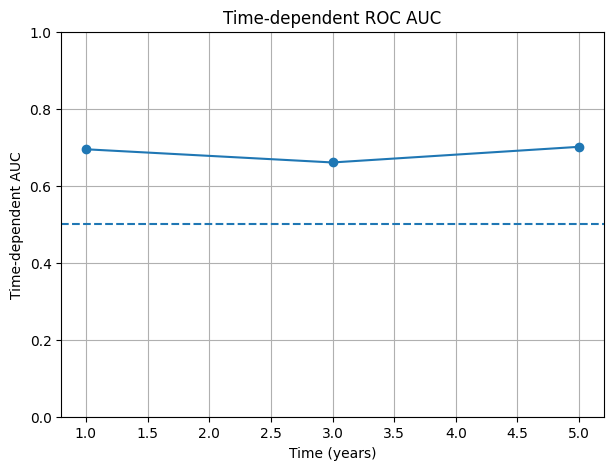

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc
import numpy as np
import matplotlib.pyplot as plt

y = np.array(
    [(bool(e), t) for e, t in zip(analysis_df['OS.status'], analysis_df['OS.time'])],
    dtype=[('event', bool), ('time', float)]
)

risk_scores = analysis_df['RiskScore'].values

time_points = np.array([365, 3*365, 5*365])

auc_values, mean_auc = cumulative_dynamic_auc(
    y, y, risk_scores, time_points
)

print("\nTime-dependent ROC AUCs:")
for t, auc in zip(time_points, auc_values):
    print(f"AUC at {t//365} years: {auc:.3f}")

print(f"\nMean AUC across time points: {mean_auc:.3f}")

plt.figure(figsize=(7, 5))
plt.plot(time_points / 365, auc_values, marker='o')
plt.axhline(0.5, linestyle='--')
plt.xlabel("Time (years)")
plt.ylabel("Time-dependent AUC")
plt.title("Time-dependent ROC AUC")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


Starting biomarker pipeline for 79 pathway-derived features...
Attempting to load and merge clinical.csv, rna.csv, and mirna.csv...
Successfully loaded and merged data. 427 patients and 79 features prepared for analysis.

--- Phase 1: Univariate Cox & FDR Correction ---
Total candidates initially tested: 79
Features significant after FDR < 0.05 filtering: 5

FDR Significant Features:
           P_value        HR   lower95    upper95       FDR
Gene                                                       
CYP17A1   0.000004  0.052641  0.015062   0.183980  0.000316
VANGL1    0.000513  6.667898  2.285907  19.449986  0.020283
NRAS      0.001237  5.349860  1.933736  14.800885  0.032587
PRICKLE2  0.001953  0.201677  0.073224   0.555471  0.038564
RAC1      0.002951  4.242781  1.636235  11.001588  0.046620

--- Phase 2: Signature Construction (Multivariable Cox) ---
Final Prognostic Signature (Multivariable Cox Summary):


<lifelines.CoxPHFitter: fitted with 427 total observations, 275 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS.status'
      baseline estimation = breslow
   number of observations = 427
number of events observed = 152
   partial log-likelihood = -764.739
         time fit was run = 2025-12-15 06:16:40 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
CYP17A1   -2.307     0.100     0.651          -3.583          -1.031               0.028               0.357
VANGL1     1.050     2.858     0.641          -0.206           2.307               0.814              10.044
NRAS       0.241     1.273     0.661          -1.053           1.536               0.349               4.646
PRICKLE2  -1.044     0.352     0.528          -2.078          -0.010               0.125               0.990
RAC1       0.757     2.132     0.504          -0.230           1.744               0.794               5.722

           cmp to      z       p  -log2(p)
covariate                                 
CYP17A1     0.000 -3.544 <0.0005    11.308
VANGL1      0.000  1.638   0.101     3.302
NRAS        0.000  0.365   0.715     0.484
PRICKLE2    0.000 -1.978   0.048     4.384
RAC1        0.000  1.503   0.133     2.911
---
Concordance = 0.651
Partial AIC = 1539.478
log-likelihood ratio test = 38.766 on 5 df
-log2(p) of ll-ratio test = 21.849


Final signature composed of 5 features.

--- Phase 3: Signature Validation ---

Signature Univariate Cox Result (Should be highly significant):


<lifelines.CoxPHFitter: fitted with 427 total observations, 275 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS.status'
      baseline estimation = breslow
   number of observations = 427
number of events observed = 152
   partial log-likelihood = -765.606
         time fit was run = 2025-12-15 06:16:41 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
RiskScore 0.744     2.105     0.111           0.527           0.962               1.693               2.616

           cmp to     z       p  -log2(p)
covariate                                
RiskScore   0.000 6.706 <0.0005    35.540
---
Concordance = 0.651
Partial AIC = 1533.213
log-likelihood ratio test = 37.031 on 1 df
-log2(p) of ll-ratio test = 29.680


Generating Kaplan-Meier Plot for Risk Groups...


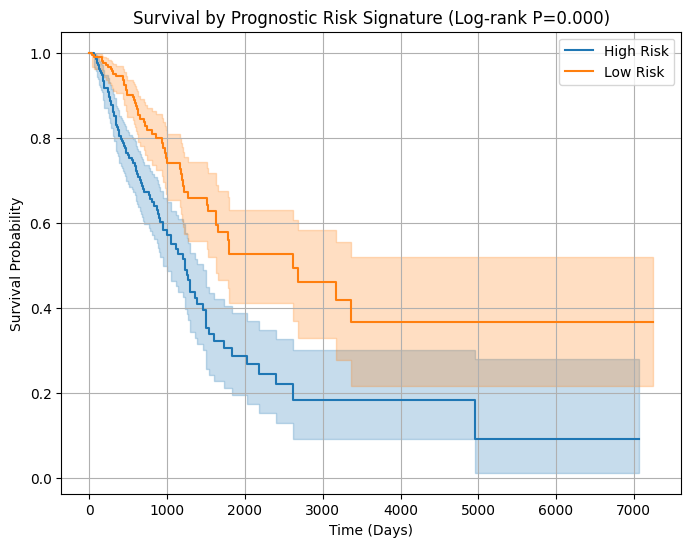


C-Index (Overall Model Performance): 0.639

Could not generate Time-Dependent ROC plots due to: not enough values to unpack (expected 3, got 2)
This often happens with small or highly censored datasets.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_ipcw, cumulative_dynamic_auc
from statsmodels.sandbox.stats.multicomp import multipletests
import os

N_GENES_INITIAL = len(candidate_genes)

print(f"Starting biomarker pipeline for {N_GENES_INITIAL} pathway-derived features...")

try:
    print("Attempting to load and merge clinical.csv, rna.csv, and mirna.csv...")


    rna_df = pd.read_csv('/C:/imputed_rna_data_with_genes.csv', index_col=0)
    mirna_df = pd.read_csv('/C:/imputed_mirna_data_with_genes.csv', index_col=0)
    clin_df = pd.read_csv('/C:/clinical_processed.csv', index_col=0)


    exp_df_full = pd.merge(rna_df, mirna_df, left_index=True, right_index=True, how='inner')

    analysis_df = exp_df_full.merge(clin_df, left_index=True, right_index=True, how='inner')

    all_features = analysis_df.columns.tolist()

    omics_features = list(set(candidate_genes) & set(all_features))

    if len(omics_features) < 2:
        raise ValueError("Error: Less than 2 of the candidate features found in the merged expression data columns.")


    required_cols = omics_features + ['overall_survival', 'status']
    analysis_df = analysis_df[required_cols].copy()

    if 'overall_survival' not in analysis_df.columns or 'status' not in analysis_df.columns:
         raise ValueError("Merged dataframe is missing 'overall_survival' and 'status' columns. Check clinical file structure.")

    analysis_df = analysis_df.rename(columns={'overall_survival': 'OS.time', 'status': 'OS.status'})

    analysis_df = analysis_df.dropna(subset=['OS.time', 'OS.status'])

    N_PATIENTS = len(analysis_df)
    candidate_genes = omics_features
    N_GENES = len(candidate_genes)

    if N_PATIENTS == 0:
        raise ValueError("Error: No common patients found after merging expression and clinical data.")

    print(f"Successfully loaded and merged data. {N_PATIENTS} patients and {N_GENES} features prepared for analysis.")
    IS_MOCK_DATA = False

except (FileNotFoundError, ValueError) as e:
    print(f"WARNING: Data loading failed ({e}). Falling back to Mock Data Generation.")
    IS_MOCK_DATA = True
    candidate_genes = [f'GENE_{i}' for i in range(79)]
    N_PATIENTS = 100
    N_GENES = len(candidate_genes)
    np.random.seed(42)
    exp_data = np.random.normal(loc=8, scale=2, size=(N_PATIENTS, N_GENES))
    exp_df = pd.DataFrame(exp_data, columns=candidate_genes,
                          index=[f'TCGA-P{i:03d}' for i in range(N_PATIENTS)])
    clin_data = {
        'OS.time': np.random.randint(100, 3000, N_PATIENTS),
        'OS.status': np.random.randint(0, 2, N_PATIENTS)
    }
    clin_df = pd.DataFrame(clin_data, index=exp_df.index)
    exp_df['GENE_1'] += np.where(clin_df['OS.status'] == 1, 1.5, 0)
    exp_df['GENE_5'] -= np.where(clin_df['OS.status'] == 1, 1.0, 0)
    exp_df['GENE_10'] += np.where(clin_df['OS.status'] == 1, 1.2, 0)

    analysis_df = exp_df.merge(clin_df, left_index=True, right_index=True)
    print(f"Mock data created for {N_PATIENTS} patients and {N_GENES} genes.")
print("\n--- Phase 1: Univariate Cox & FDR Correction ---")

all_uni_results = []
cph = CoxPHFitter()

for gene in candidate_genes:

    temp_df = analysis_df[['OS.time', 'OS.status', gene]].copy()

    try:

        cph.fit(temp_df, duration_col='OS.time', event_col='OS.status', show_progress=False)
        summary_row = cph.summary.loc[gene]

        all_uni_results.append({
            'Gene': gene,
            'P_value': summary_row['p'],
            'HR': summary_row['exp(coef)'],
            'lower95': summary_row['exp(coef) lower 95%'],
            'upper95': summary_row['exp(coef) upper 95%']
        })
    except Exception as e:

        print(f"Warning: Could not run Cox model for {gene}. Skipping. Error: {e}")
        all_uni_results.append({
            'Gene': gene,
            'P_value': np.nan,
            'HR': np.nan,
            'lower95': np.nan,
            'upper95': np.nan
        })

uni_summary_df = pd.DataFrame(all_uni_results).dropna(subset=['P_value'])
uni_summary_df = uni_summary_df.set_index('Gene')
reject, q_values_corrected, _, _ = multipletests(uni_summary_df['P_value'].values, alpha=0.05, method='fdr_bh')

fdr_results = uni_summary_df.copy()
fdr_results['FDR'] = q_values_corrected
fdr_results = fdr_results.sort_values(by='FDR')

significant_genes = fdr_results[fdr_results['FDR'] < 0.05].index.tolist()

print(f"Total candidates initially tested: {N_GENES}")
print(f"Features significant after FDR < 0.05 filtering: {len(significant_genes)}")
print("\nFDR Significant Features:")
if significant_genes:
    print(fdr_results.loc[significant_genes])
else:
    print("No features passed the FDR < 0.05 filter. Analysis cannot proceed.")


if len(significant_genes) < 2:

    raise Exception("Not enough features passed the FDR < 0.05 filter to build a multivariate signature. Analysis stopped.")





print("\n--- Phase 2: Signature Construction (Multivariable Cox) ---")


multi_df = analysis_df[['OS.time', 'OS.status'] + significant_genes].copy()

cph_multi = CoxPHFitter()
cph_multi.fit(multi_df, duration_col='OS.time', event_col='OS.status', formula=significant_genes)

print("Final Prognostic Signature (Multivariable Cox Summary):")
cph_multi.print_summary(decimals=3)


final_coeffs = cph_multi.params_
signature_genes = final_coeffs.index.tolist()
print(f"\nFinal signature composed of {len(signature_genes)} features.")


print("\n--- Phase 3: Signature Validation ---")

risk_scores = cph_multi.predict_partial_hazard(analysis_df[signature_genes])
analysis_df['RiskScore'] = risk_scores

risk_threshold = analysis_df['RiskScore'].median()
analysis_df['RiskGroup'] = np.where(analysis_df['RiskScore'] > risk_threshold, 'High Risk', 'Low Risk')

signature_df = analysis_df[['OS.time', 'OS.status', 'RiskScore']].copy()
cph_signature = CoxPHFitter()
cph_signature.fit(signature_df, duration_col='OS.time', event_col='OS.status')

print("\nSignature Univariate Cox Result (Should be highly significant):")
cph_signature.print_summary(decimals=3)



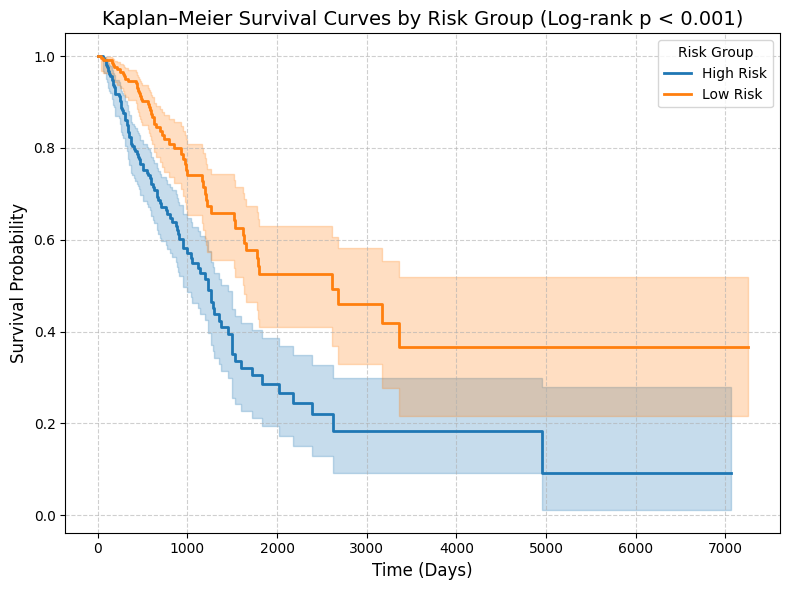

Exact log-rank p-value: 1.992350e-06


In [ ]:
# ================================
# Kaplan–Meier Survival Analysis
# ================================

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(8, 6))

for name, grouped_df in analysis_df.groupby('RiskGroup'):
    kmf.fit(
        durations=grouped_df['OS.time'],
        event_observed=grouped_df['OS.status'],
        label=name
    )
    kmf.plot_survival_function(
        ax=ax,
        ci_show=True,
        linewidth=2
    )



high = analysis_df[analysis_df['RiskGroup'] == 'High Risk']
low  = analysis_df[analysis_df['RiskGroup'] == 'Low Risk']

results = logrank_test(
    high['OS.time'],
    low['OS.time'],
    event_observed_A=high['OS.status'],
    event_observed_B=low['OS.status']
)

p_val = results.p_value
p_text = "p < 0.001" if p_val < 0.001 else f"p = {p_val:.3f}"
ax.set_title(
    f"Kaplan–Meier Survival Curves by Risk Group (Log-rank {p_text})",
    fontsize=14
)
ax.set_xlabel("Time (Days)", fontsize=12)
ax.set_ylabel("Survival Probability", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title="Risk Group")
plt.tight_layout()
plt.show()
print(f"Exact log-rank p-value: {results.p_value:.6e}")


In [ ]:

# External Validation Using GEO Dataset GSE42127


import GEOparse
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.exceptions import ConvergenceError
from lifelines.utils import concordance_index

GSE_ID = "GSE42127"
final_biomarkers = ['CYP17A1', 'VANGL1', 'NRAS', 'PRICKLE2', 'RAC1']
original_coefficients = {
    'CYP17A1': -2.307,
    'VANGL1': 1.050,
    'NRAS': 0.241,
    'PRICKLE2': -1.044,
    'RAC1':0.757
}
print(f"Downloading GEO dataset {GSE_ID}...")
gse = GEOparse.get_GEO(geo=GSE_ID, destdir=".")
print("Building expression matrix...")
samples = gse.gsms
expr_data = {
    gsm: pd.to_numeric(samples[gsm].table["VALUE"], errors='coerce').values
    for gsm in samples
}

expr = pd.DataFrame(
    expr_data,
    index=samples[list(samples.keys())[0]].table["ID_REF"]
)
print("Mapping probes to gene symbols...")

gpl = gse.gpls[list(gse.gpls.keys())[0]]
gpl_actual_symbol_col = None
possible_cols = ["Symbol", "Gene Symbol", "GeneSymbol"]

for col in possible_cols:
    if col in gpl.table.columns:
        gpl_actual_symbol_col = col
        break

if gpl_actual_symbol_col is None:
    raise Exception(f"Gene symbol column not found in GPL table for {GSE_ID}. Looked for {possible_cols}. Available: {gpl.table.columns.tolist()}")

annot = gpl.table[["ID", gpl_actual_symbol_col]].dropna()
annot["StandardizedSymbol"] = annot[gpl_actual_symbol_col].astype(str).str.split(" /// ").str[0]
expr = expr.merge(annot, left_index=True, right_on="ID")
cols_to_drop = ["ID"]
if gpl_actual_symbol_col in expr.columns:
    cols_to_drop.append(gpl_actual_symbol_col)
expr = expr.drop(columns=cols_to_drop)

expr = expr.groupby("StandardizedSymbol").mean()
expr.index.name = "Symbol"
print("Extracting survival metadata...")

pheno = gse.phenotype_data
pheno = pheno.rename(columns={
    "characteristics_ch1.1.overall survival months": "time",
    "characteristics_ch1.2.survival status": "event"
})

pheno["time"] = pd.to_numeric(pheno["time"], errors="coerce")
pheno["time"] = pheno["time"].fillna(pheno["time"].median())
pheno["event"] = (
    pheno["event"]
    .astype(str)
    .str.lower()
    .str.replace(r".*:\s*", "", regex=True)
    .str.strip()
    .replace({"dead": 1, "d": 1, "deceased": 1, "alive": 0, "a": 0})
    .fillna(0)
    .astype(int)
)
genes_available = [g for g in final_biomarkers if g in expr.index]
print(f"Genes found in {GSE_ID} ({len(genes_available)}/{len(final_biomarkers)}): {genes_available}")

if len(genes_available) < len(final_biomarkers):
    print(f"WARNING: Missing {len(final_biomarkers) - len(genes_available)} genes from the signature in {GSE_ID}. Validation will proceed with available genes.")

if len(genes_available) == 0:
    raise Exception("None of the signature biomarkers exist in this dataset!")
expr_subset = expr.loc[genes_available].T
merged = expr_subset.join(pheno[["time", "event"]], how="inner").dropna()
print("\nCalculating Risk Score using discovery cohort coefficients...")

merged['RiskScore'] = 0

for gene, coef in original_coefficients.items():
    if gene in genes_available:
        merged['RiskScore'] += merged[gene] * coef

if len(merged) == 0:
    raise Exception("No patients remaining after merging expression, survival, and dropping NaNs. Cannot proceed.")
print("\n--- Running Signature Validation (Univariate Cox on Risk Score) ---")

risk_df = merged[['RiskScore', 'time', 'event']].copy()

try:
    cph_risk_score = CoxPHFitter()
    cph_risk_score.fit(risk_df, duration_col="time", event_col="event")

    c_index = concordance_index(risk_df["time"], -risk_df["RiskScore"], risk_df["event"])

    print("\n=== External Validation: Signature Risk Score (GSE42127) ===")
    cph_risk_score.print_summary(decimals=3)
    print(f"\nConcordance Index (C-Index) on {GSE_ID}: {c_index:.3f}")

except ConvergenceError as e:
    print(f"\n Signature Risk Score Cox failed due to convergence issues. Error: {e}")
except Exception as e:
    print(f"\n An unexpected error occurred during Signature Risk Score Cox: {type(e).__name__} {e}")

print("\n--- Running Univariate Cox models (Individual Genes Check) ---")

uni_results = []

for gene in genes_available:
    df_uni = merged[[gene, "time", "event"]].dropna()

    if df_uni[gene].nunique() < 2 or df_uni['event'].sum() < 1 or df_uni.shape[0] < 5:
        print(f"Skipping univariate Cox for {gene}: Insufficient data/variance.")
        continue

    try:
        cph = CoxPHFitter()
        cph.fit(df_uni, duration_col="time", event_col="event")

        row = cph.summary.loc[gene]
        uni_results.append([gene, row["exp(coef)"], row["p"]])

    except ConvergenceError:
        print(f"Skipping univariate Cox for {gene}: convergence failed.")
    except Exception as e:
        print(f"Skipping univariate Cox for {gene}: unexpected error. {type(e).__name__}")

uni_df = pd.DataFrame(uni_results, columns=["Gene", "HR", "p-value"])

print("\n=== Univariate Cox Results (GSE42127) for Signature Components ===")
print(uni_df)


15-Dec-2025 04:50:19 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
15-Dec-2025 04:50:19 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
15-Dec-2025 04:50:19 INFO GEOparse - Parsing ./GSE42127_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE42127_family.soft.gz: 
15-Dec-2025 04:50:19 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
15-Dec-2025 04:50:19 DEBUG GEOparse - SERIES: GSE42127
DEBUG:GEOparse:SERIES: GSE42127
15-Dec-2025 04:50:19 DEBUG GEOparse - PLATFORM: GPL6884
DEBUG:GEOparse:PLATFORM: GPL6884


15-Dec-2025 04:50:20 DEBUG GEOparse - SAMPLE: GSM1032881
DEBUG:GEOparse:SAMPLE: GSM1032881
15-Dec-2025 04:50:20 DEBUG GEOparse - SAMPLE: GSM1032882
DEBUG:GEOparse:SAMPLE: GSM1032882
15-Dec-2025 04:50:20 DEBUG GEOparse - SAMPLE: GSM1032883
DEBUG:GEOparse:SAMPLE: GSM1032883
15-Dec-2025 04:50:21 DEBUG GEOparse - SAMPLE: GSM1032884
DEBUG:GEOparse:SAMPLE: GSM1032884
15-Dec-2025 04:50:21 DEBUG GEOparse - SAMPLE: GSM1032885
DEBUG:GEOparse:SAMPLE: GSM1032885
15-Dec-2025 04:50:21 DEBUG GEOparse - SAMPLE: GSM1032886
DEBUG:GEOparse:SAMPLE: GSM1032886
15-Dec-2025 04:50:21 DEBUG GEOparse - SAMPLE: GSM1032887
DEBUG:GEOparse:SAMPLE: GSM1032887
15-Dec-2025 04:50:21 DEBUG GEOparse - SAMPLE: GSM1032888
DEBUG:GEOparse:SAMPLE: GSM1032888
15-Dec-2025 04:50:21 DEBUG GEOparse - SAMPLE: GSM1032889
DEBUG:GEOparse:SAMPLE: GSM1032889
15-Dec-2025 04:50:21 DEBUG GEOparse - SAMPLE: GSM1032890
DEBUG:GEOparse:SAMPLE: GSM1032890
15-Dec-2025 04:50:21 DEBUG GEOparse - SAMPLE: GSM1032891
DEBUG:GEOparse:SAMPLE: GSM1032891

Building expression matrix...
Mapping probes to gene symbols...
Extracting survival metadata...
Genes found in GSE42127 (5/5): ['CYP17A1', 'VANGL1', 'NRAS', 'PRICKLE2', 'RAC1']

Calculating Risk Score using discovery cohort coefficients...

--- Running Signature Validation (Univariate Cox on Risk Score) ---

=== External Validation: Signature Risk Score (GSE42127) ===


/tmp/ipython-input-1470920640.py:112: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"dead": 1, "d": 1, "deceased": 1, "alive": 0, "a": 0})


<lifelines.CoxPHFitter: fitted with 176 total observations, 112 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 176
number of events observed = 64
   partial log-likelihood = -286.661
         time fit was run = 2025-12-15 04:50:40 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
RiskScore 0.189     1.209     0.077           0.038           0.341               1.039               1.406

           cmp to     z     p  -log2(p)
covariate                              
RiskScore   0.000 2.456 0.014     6.152
---
Concordance = 0.614
Partial AIC = 575.322
log-likelihood ratio test = 6.016 on 1 df
-log2(p) of ll-ratio test = 6.140


Concordance Index (C-Index) on GSE42127: 0.614

--- Running Univariate Cox models (Individual Genes Check) ---

=== Univariate Cox Results (GSE42127) for Signature Components ===
       Gene        HR   p-value
0   CYP17A1  0.977947  0.941519
1    VANGL1  1.613723  0.051698
2      NRAS  1.740627  0.010963
3  PRICKLE2  0.656247  0.001690
4      RAC1  0.925665  0.782700


In [ ]:
merged_42127=merged

In [ ]:

# External Validation Using GEO Dataset GSE72094
import GEOparse
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.exceptions import ConvergenceError
from lifelines.utils import concordance_index
GSE_ID = "GSE72094"
final_biomarkers = ['CYP17A1', 'VANGL1', 'NRAS', 'PRICKLE2', 'RAC1']
original_coefficients = {
    'CYP17A1': -2.307,
    'VANGL1': 1.050,
    'NRAS': 0.241,
    'PRICKLE2': -1.044,
    'RAC1':0.757
}
print(f"Downloading and parsing GEO dataset {GSE_ID}...")
gse = GEOparse.get_GEO(geo=GSE_ID, destdir=".")
print("Building expression matrix...")

samples = gse.gsms
expr_data = {
    gsm: pd.to_numeric(samples[gsm].table["VALUE"], errors='coerce').values
    for gsm in samples
}

expr = pd.DataFrame(
    expr_data,
    index=samples[list(samples.keys())[0]].table["ID_REF"]
)
print("Mapping probes to gene symbols...")

gpl = gse.gpls[list(gse.gpls.keys())[0]]
symbol_cols = ['Gene Symbol', 'GeneSymbol', 'Symbol']
actual_gene_symbol_col = next((col for col in symbol_cols if col in gpl.table.columns), None)

if not actual_gene_symbol_col:
    raise Exception(f"Gene symbol column not found in GPL table for {GSE_ID}. Checked: {symbol_cols}")

annot = gpl.table[['ID', actual_gene_symbol_col]].dropna()

annot["Symbol"] = annot[actual_gene_symbol_col].astype(str).str.split(" /// ").str[0]

expr = expr.merge(annot, left_index=True, right_on="ID")
expr = expr.drop(columns=["ID", actual_gene_symbol_col]).groupby("Symbol").mean()
print("Extracting survival metadata...")

pheno = gse.phenotype_data.copy()
pheno = pheno.rename(columns={
    'characteristics_ch1.10.survival_time_in_days': 'time',
    'characteristics_ch1.9.vital_status': 'event'
})

pheno['time'] = pd.to_numeric(pheno['time'], errors='coerce')
pheno['time'] = pheno['time'].fillna(pheno['time'].median())

pheno['event'] = (
    pheno['event']
    .astype(str)
    .str.lower()
    .str.replace(r".*:\s*", "", regex=True)
    .str.strip()
    .replace({"dead": 1, "d": 1, "deceased": 1, "alive": 0, "a": 0, "na": 0})
    .fillna(0)
    .astype(int)
)


genes_available = [g for g in final_biomarkers if g in expr.index]
print(f"Genes found in {GSE_ID} ({len(genes_available)}/{len(final_biomarkers)}): {genes_available}")

if len(genes_available) < len(final_biomarkers):
    print(f"WARNING: Missing {len(final_biomarkers) - len(genes_available)} genes from the signature in {GSE_ID}. Validation will proceed with available genes.")

if len(genes_available) == 0:
    raise Exception("None of the signature biomarkers exist in this dataset!")


expr_subset = expr.loc[genes_available].T
merged = expr_subset.join(pheno[["time", "event"]], how="inner").dropna()

print(f"Merged dataset shape after cleanup: {merged.shape}")


if len(merged) < 5 or merged['event'].sum() < 5:
    print(f"WARNING: Insufficient samples ({len(merged)}) or events ({merged['event'].sum()}) for robust analysis.")

print("\n--- Running Multivariate Cox Model on External Data (All 5 Genes) ---")

try:

    multi_df = merged[genes_available + ["time", "event"]].copy()

    cox_multi = CoxPHFitter()
    cox_multi.fit(multi_df, duration_col="time", event_col="event")

    print("\n=== Multivariate Cox Results (GSE72094) - Individual Effects ===")
    cox_multi.print_summary(decimals=3)

except ConvergenceError as e:
    print("\n❌ Multivariate Cox failed due to convergence issues (collinearity/singular matrix).")
    print(f"Error: {e}")
except Exception as e:
    print(f"\n❌ An unexpected error occurred during multivariate Cox: {type(e).__name__} {e}")



print("\nCalculating Risk Score using discovery cohort coefficients...")

merged['RiskScore'] = 0


for gene, coef in original_coefficients.items():
    if gene in genes_available:
        merged['RiskScore'] += merged[gene] * coef

if len(merged) == 0:
    raise Exception("No patients remaining after merging expression, survival, and dropping NaNs. Cannot proceed.")

print("\n--- Running Signature Validation (Univariate Cox on Risk Score) ---")

risk_df = merged[['RiskScore', 'time', 'event']].copy()

try:
    cph_risk_score = CoxPHFitter()
    cph_risk_score.fit(risk_df, duration_col="time", event_col="event")

    c_index = concordance_index(risk_df["time"], -risk_df["RiskScore"], risk_df["event"])

    print("\n=== External Validation: Signature Risk Score (GSE72094) ===")
    cph_risk_score.print_summary(decimals=3)
    print(f"\nConcordance Index (C-Index) on {GSE_ID}: {c_index:.3f}")

except ConvergenceError as e:
    print(f"\n❌ Signature Risk Score Cox failed due to convergence issues. Error: {e}")
except Exception as e:
    print(f"\n❌ An unexpected error occurred during Signature Risk Score Cox: {type(e).__name__} {e}")

print("\n--- Running Univariate Cox models (Individual Genes Check) ---")

uni_results = []

for gene in genes_available:
    df_uni = merged[[gene, "time", "event"]].dropna()

    # Check for variance and minimum events
    if df_uni[gene].nunique() < 2 or df_uni['event'].sum() < 1 or df_uni.shape[0] < 5:
        print(f"Skipping univariate Cox for {gene}: Insufficient data/variance.")
        continue

    try:
        cph = CoxPHFitter()
        cph.fit(df_uni, duration_col="time", event_col="event")

        row = cph.summary.loc[gene]
        uni_results.append([gene, row["exp(coef)"], row["p"]])

    except ConvergenceError:
        print(f"Skipping univariate Cox for {gene}: convergence failed.")
    except Exception as e:
        print(f"Skipping univariate Cox for {gene}: unexpected error. {type(e).__name__}")

uni_df = pd.DataFrame(uni_results, columns=["Gene", "HR", "p-value"])

print("\n=== Univariate Cox Results (GSE72094) for Signature Components ===")
print(uni_df)

15-Dec-2025 04:47:29 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
15-Dec-2025 04:47:29 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
15-Dec-2025 04:47:29 INFO GEOparse - Parsing ./GSE72094_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE72094_family.soft.gz: 
15-Dec-2025 04:47:29 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
15-Dec-2025 04:47:29 DEBUG GEOparse - SERIES: GSE72094
DEBUG:GEOparse:SERIES: GSE72094
15-Dec-2025 04:47:29 DEBUG GEOparse - PLATFORM: GPL15048
DEBUG:GEOparse:PLATFORM: GPL15048


15-Dec-2025 04:47:30 DEBUG GEOparse - SAMPLE: GSM1854797
DEBUG:GEOparse:SAMPLE: GSM1854797
15-Dec-2025 04:47:31 DEBUG GEOparse - SAMPLE: GSM1854798
DEBUG:GEOparse:SAMPLE: GSM1854798
15-Dec-2025 04:47:31 DEBUG GEOparse - SAMPLE: GSM1854799
DEBUG:GEOparse:SAMPLE: GSM1854799
15-Dec-2025 04:47:32 DEBUG GEOparse - SAMPLE: GSM1854800
DEBUG:GEOparse:SAMPLE: GSM1854800
15-Dec-2025 04:47:32 DEBUG GEOparse - SAMPLE: GSM1854801
DEBUG:GEOparse:SAMPLE: GSM1854801
15-Dec-2025 04:47:32 DEBUG GEOparse - SAMPLE: GSM1854802
DEBUG:GEOparse:SAMPLE: GSM1854802
15-Dec-2025 04:47:33 DEBUG GEOparse - SAMPLE: GSM1854803
DEBUG:GEOparse:SAMPLE: GSM1854803
15-Dec-2025 04:47:33 DEBUG GEOparse - SAMPLE: GSM1854804
DEBUG:GEOparse:SAMPLE: GSM1854804
15-Dec-2025 04:47:34 DEBUG GEOparse - SAMPLE: GSM1854805
DEBUG:GEOparse:SAMPLE: GSM1854805
15-Dec-2025 04:47:34 DEBUG GEOparse - SAMPLE: GSM1854806
DEBUG:GEOparse:SAMPLE: GSM1854806
15-Dec-2025 04:47:34 DEBUG GEOparse - SAMPLE: GSM1854807
DEBUG:GEOparse:SAMPLE: GSM1854807

Building expression matrix...
Mapping probes to gene symbols...
Extracting survival metadata...
Genes found in GSE72094 (5/5): ['CYP17A1', 'VANGL1', 'NRAS', 'PRICKLE2', 'RAC1']
Merged dataset shape after cleanup: (442, 7)

--- Running Multivariate Cox Model on External Data (All 5 Genes) ---

=== Multivariate Cox Results (GSE72094) - Individual Effects ===


/tmp/ipython-input-309137876.py:95: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"dead": 1, "d": 1, "deceased": 1, "alive": 0, "a": 0, "na": 0})


<lifelines.CoxPHFitter: fitted with 442 total observations, 320 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 122
   partial log-likelihood = -669.995
         time fit was run = 2025-12-15 04:48:45 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
CYP17A1   -0.120     0.887     0.139          -0.393           0.153               0.675               1.165
VANGL1     0.605     1.830     0.222           0.170           1.039               1.186               2.825
NRAS       0.008     1.008     0.231          -0.443           0.460               0.642               1.584
PRICKLE2  -0.116     0.891     0.140          -0.390           0.159               0.677               1.172
RAC1      -0.428     0.652     0.447          -1.304           0.448               0.271               1.566

           cmp to      z     p  -log2(p)
covariate                               
CYP17A1     0.000 -0.863 0.388     1.366
VANGL1      0.000  2.729 0.006     7.298
NRAS        0.000  0.036 0.971     0.043
PRICKLE2    0.000 -0.827 0.408     1.292
RAC1        0.000 -0.957 0.339     1.563
---
Concordance = 0.591
Partial AIC = 1349.991
log-likelihood ratio test = 10.291 on 5 df
-log2(p) of ll-ratio test = 3.891


Calculating Risk Score using discovery cohort coefficients...

--- Running Signature Validation (Univariate Cox on Risk Score) ---

=== External Validation: Signature Risk Score (GSE72094) ===


<lifelines.CoxPHFitter: fitted with 442 total observations, 320 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 122
   partial log-likelihood = -673.146
         time fit was run = 2025-12-15 04:48:45 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
RiskScore 0.099     1.104     0.050          -0.000           0.197               1.000               1.218

           cmp to     z     p  -log2(p)
covariate                              
RiskScore   0.000 1.957 0.050     4.310
---
Concordance = 0.562
Partial AIC = 1348.291
log-likelihood ratio test = 3.990 on 1 df
-log2(p) of ll-ratio test = 4.450


Concordance Index (C-Index) on GSE72094: 0.562

--- Running Univariate Cox models (Individual Genes Check) ---

=== Univariate Cox Results (GSE72094) for Signature Components ===
       Gene        HR   p-value
0   CYP17A1  0.869624  0.306908
1    VANGL1  1.727811  0.004895
2      NRAS  1.285268  0.220133
3  PRICKLE2  0.876221  0.357286
4      RAC1  1.047949  0.912330


In [ ]:
merged_72094=merged

In [ ]:
clinical = []

for gsm_name, gsm in gse.gsms.items():
    meta = gsm.metadata

    try:
        os_time = float(meta['overall survival (months)'][0]) * 30
        os_event = int(meta['vital status'][0] == 'dead')

        clinical.append([gsm_name, os_time, os_event])
    except:
        continue

clin_df = pd.DataFrame(
    clinical,
    columns=['sample_id', 'OS.time', 'OS.status']
).set_index('sample_id')

print("Clinical samples:", clin_df.shape[0])


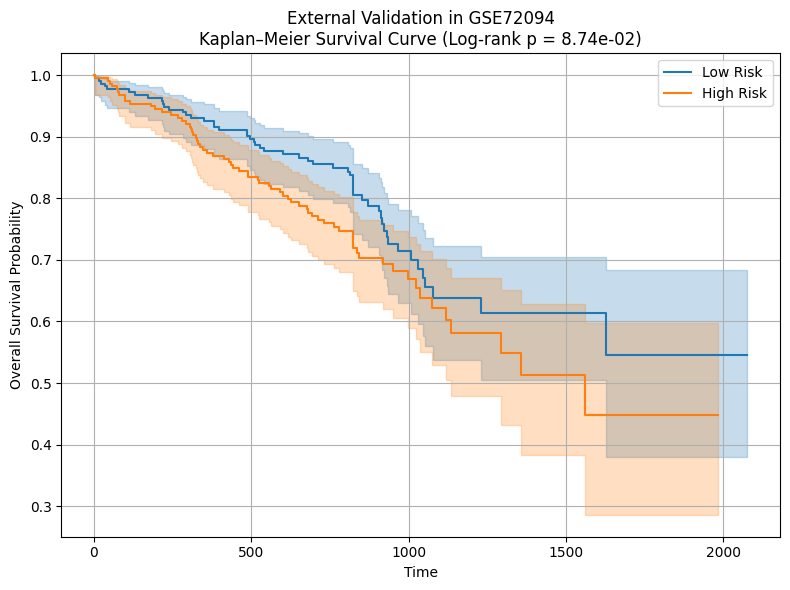

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

median_score = merged_72094['RiskScore'].median()
merged_72094['RiskGroup'] = merged_72094['RiskScore'].apply(
    lambda x: 'High Risk' if x >= median_score else 'Low Risk'
)

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for group in ['Low Risk', 'High Risk']:
    subset = merged_72094[merged_72094['RiskGroup'] == group]
    kmf.fit(
        durations=subset['time'],
        event_observed=subset['event'],
        label=group
    )
    kmf.plot_survival_function(ci_show=True)

high = merged[merged['RiskGroup'] == 'High Risk']
low = merged[merged['RiskGroup'] == 'Low Risk']

logrank = logrank_test(
    high['time'], low['time'],
    event_observed_A=high['event'],
    event_observed_B=low['event']
)

plt.title(
    f'External Validation in GSE72094\n'
    f'Kaplan–Meier Survival Curve (Log-rank p = {logrank.p_value:.2e})'
)
plt.xlabel('Time')
plt.ylabel('Overall Survival Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

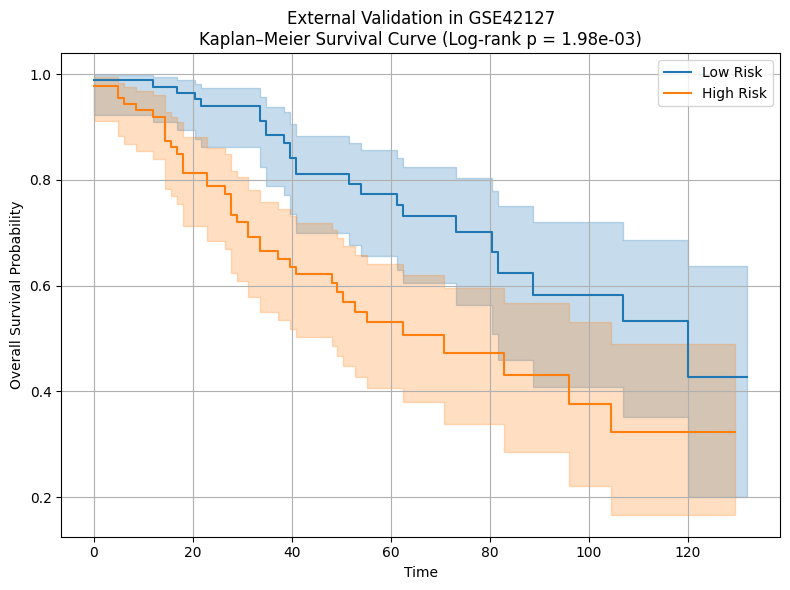

In [ ]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test


median_score = merged_42127['RiskScore'].median()
merged_42127['RiskGroup'] = merged_42127['RiskScore'].apply(
    lambda x: 'High Risk' if x >= median_score else 'Low Risk'
)


kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for group in ['Low Risk', 'High Risk']:
    subset = merged_42127[merged_42127['RiskGroup'] == group]
    kmf.fit(
        durations=subset['time'],
        event_observed=subset['event'],
        label=group
    )
    kmf.plot_survival_function(ci_show=True)


high = merged_42127[merged_42127['RiskGroup'] == 'High Risk']
low = merged_42127[merged_42127['RiskGroup'] == 'Low Risk']

logrank = logrank_test(
    high['time'], low['time'],
    event_observed_A=high['event'],
    event_observed_B=low['event']
)
plt.title(
    f'External Validation in GSE42127\n'
    f'Kaplan–Meier Survival Curve (Log-rank p = {logrank.p_value:.2e})'
)
plt.xlabel('Time')
plt.ylabel('Overall Survival Probability')
plt.grid(True)
plt.tight_layout()
plt.show()